In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Read the DataFrame from the CSV file
my_data2 = pd.read_csv('../data/pitstops_modified.csv')
my_data2.head()

,raceId,year,driverId,number_of_stops,pit_delta,race_time
0,978,2017,822,1,0.464300,81.691550
1,981,2017,822,1,0.395467,75.613050
2,981,2017,815,1,0.422950,76.793133
3,981,2017,1,1,0.395417,75.538533
4,981,2017,20,1,0.405117,76.143817


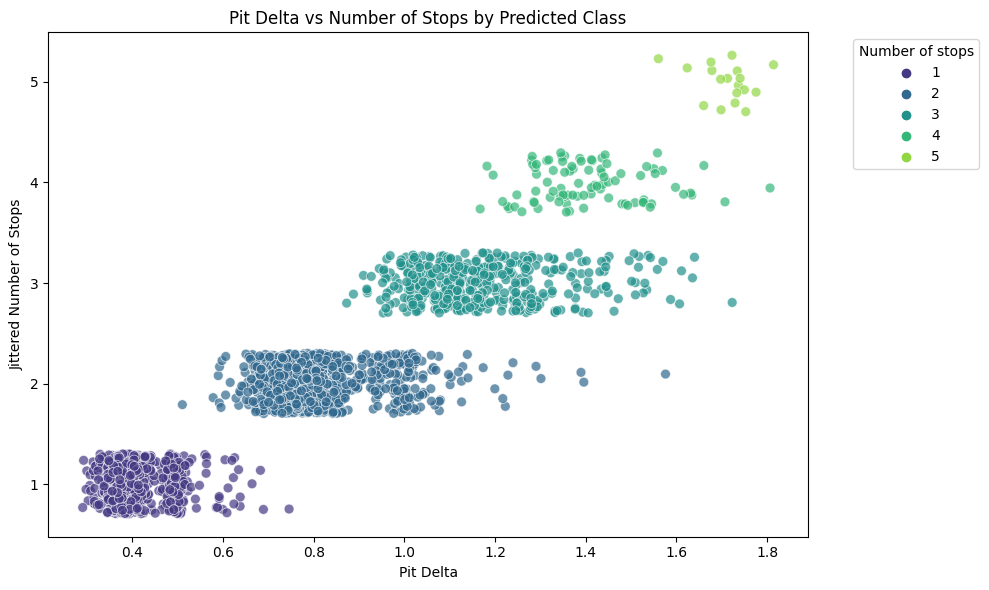

In [40]:
# Add jitter to 'number_of_stops' for visualization
# This step enhances the scatter plot by preventing overlapping points for discrete values
jitter_amount = 0.3
my_data2['jittered_number_of_stops'] = my_data2['number_of_stops'].astype(float) + np.random.uniform(-jitter_amount, jitter_amount, size=len(my_data2))

# Now, let's plot using seaborn for a cleaner and more integrated approach
plt.figure(figsize=(10, 6))

# Using seaborn's scatterplot function to automatically handle coloring based on 'predicted_class'
# The 'hue' parameter controls the color of points based on 'predicted_class'
sns.scatterplot(data=my_data2, x='pit_delta', y='jittered_number_of_stops', hue='number_of_stops', palette='viridis', alpha=0.7, s=50)

plt.title('Pit Delta vs Number of Stops by Predicted Class')
plt.xlabel('Pit Delta')
plt.ylabel('Jittered Number of Stops')
plt.legend(title='Number of stops', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [11]:
# Assuming my_data2 is your DataFrame
# Make sure 'number_of_stops' is treated as a categorical variable with ordered categories
my_data2['number_of_stops'] = pd.Categorical(my_data2['number_of_stops'], ordered=True)

# Defining the independent variable (X) and the dependent variable (y)
X = my_data2[['pit_delta']]  # Predictor variable(s)
y = my_data2['number_of_stops']  # Outcome variable

# Note: Do not add a constant to X for OrderedModel
# X = sm.add_constant(X)  # Remove or comment out this line

# Creating and fitting the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')  # Using the BFGS optimizer; you can choose others like 'powell'

# Displaying the summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.257720
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:        number_of_stops   Log-Likelihood:                -604.61
Model:                   OrderedModel   AIC:                             1219.
Method:            Maximum Likelihood   BIC:                             1248.
Date:                Wed, 27 Mar 2024                                         
Time:                        23:38:03                                         
No. Observations:                2346                                         
Df Residuals:                    2341                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

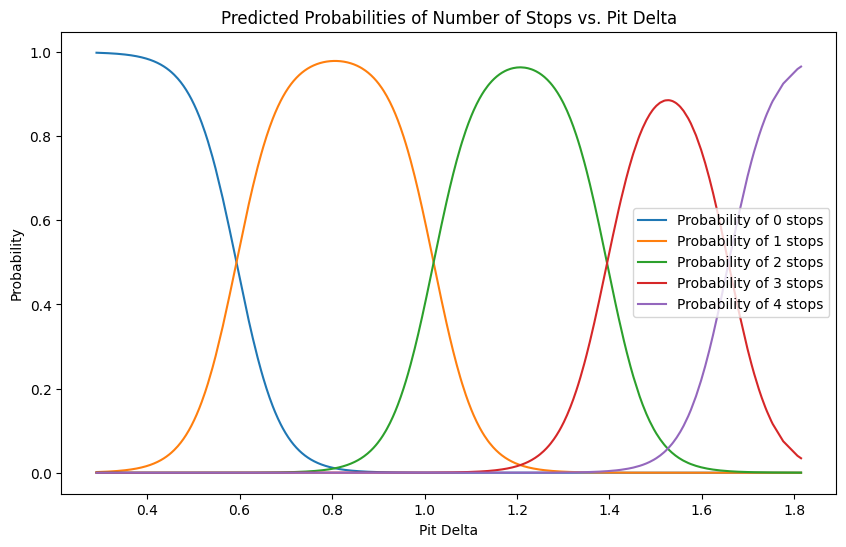

In [32]:
# Assuming result and X are defined as in the previous context
# and result.predict() was used to generate pred_probs

# Generate a sorted DataFrame for X for plotting purposes
X_sorted = X.sort_values(by='pit_delta')
x_values = X_sorted['pit_delta'].values

# Generating predicted probabilities on the sorted X values
pred_probs = result.predict(X_sorted) 

# Assuming pred_probs is a DataFrame where each column represents a category
if isinstance(pred_probs, pd.DataFrame):
    categories = pred_probs.columns  # Assuming column names match categories
else:
    # If pred_probs is not a DataFrame, adjust categories accordingly
    categories = range(pred_probs.shape[1])

plt.figure(figsize=(10, 6))

# Iterate over the columns in pred_probs if it's a DataFrame
for i, category in enumerate(categories):
    # Extract the probability series for the current category
    prob_series = pred_probs[category] if isinstance(pred_probs, pd.DataFrame) else pred_probs[:, i]
    plt.plot(x_values, prob_series, label=f'Probability of {category} stops')

plt.title('Predicted Probabilities of Number of Stops vs. Pit Delta')
plt.xlabel('Pit Delta')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [20]:
# Calculate the most likely class for each observation
pred_classes = pred_probs.idxmax(axis=1) + 1

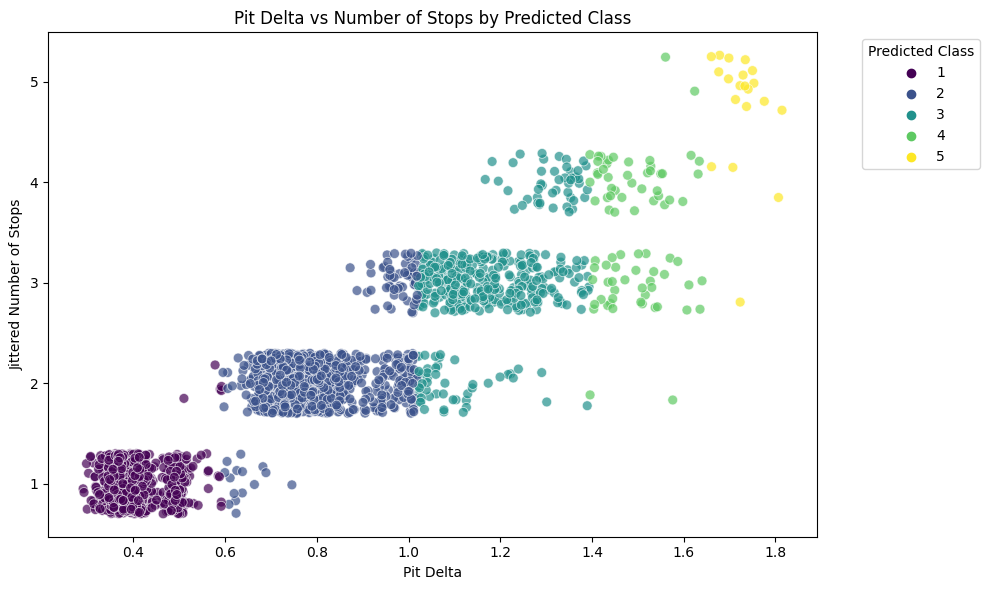

In [38]:
# Add predicted classes to 'my_data2' for plotting
my_data2['predicted_class'] = pred_classes  # Assuming pred_classes is a Series or list aligned with my_data2's index

# Add jitter to 'number_of_stops' for visualization
# This step enhances the scatter plot by preventing overlapping points for discrete values
jitter_amount = 0.3
my_data2['jittered_number_of_stops'] = my_data2['number_of_stops'].astype(float) + np.random.uniform(-jitter_amount, jitter_amount, size=len(my_data2))

# Now, let's plot using seaborn for a cleaner and more integrated approach
plt.figure(figsize=(10, 6))

# Using seaborn's scatterplot function to automatically handle coloring based on 'predicted_class'
# The 'hue' parameter controls the color of points based on 'predicted_class'
sns.scatterplot(data=my_data2, x='pit_delta', y='jittered_number_of_stops', hue='predicted_class', palette='viridis', alpha=0.7, s=50)

plt.title('Pit Delta vs Number of Stops by Predicted Class')
plt.xlabel('Pit Delta')
plt.ylabel('Jittered Number of Stops')
plt.legend(title='Predicted Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [22]:
# Assuming 'pred_classes' contains the predicted classes
# Reset the index of both Series without insertion of the index into the DataFrame
actual_classes = my_data2['number_of_stops']
actual_classes_reset = actual_classes.reset_index(drop=True)
pred_classes_reset = pred_classes.reset_index(drop=True)

# Calculate the accuracy
accuracy = (pred_classes_reset == actual_classes_reset).mean()
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.99


In [24]:
my_data2.head()

,raceId,year,driverId,number_of_stops,pit_delta,race_time,predicted_class
0,978,2017,822,1,0.464300,81.691550,1
1,981,2017,822,1,0.395467,75.613050,1
2,981,2017,815,1,0.422950,76.793133,1
3,981,2017,1,1,0.395417,75.538533,1
4,981,2017,20,1,0.405117,76.143817,1


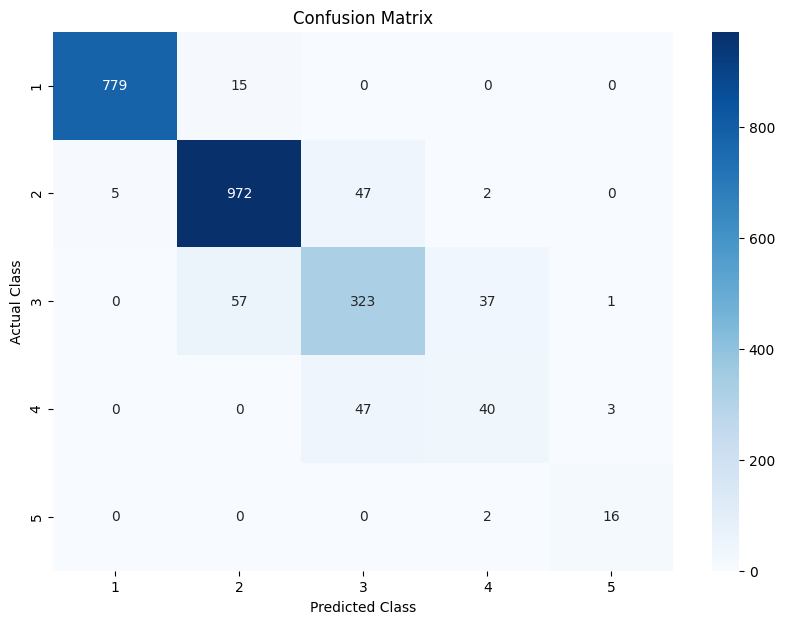

In [41]:
from sklearn.metrics import confusion_matrix

# Assuming `y_true` and `y_pred` are your actual and predicted labels, respectively
labels = [1, 2, 3, 4, 5]  # Explicitly state the labels based on your unique labels output
y_true = my_data2['number_of_stops']
y_pred = my_data2['predicted_class']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


